In [ ]:
# Install Statements

!pip install "dask[dataframe]"
!pip install cftime
!pip install utils
!pip install netCDF4 
!pip install scipy 
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Statements

import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import os
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.spatial.distance import cdist
from numpy.random import uniform
import seaborn as sns
import random
import dask.dataframe as dd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import sys 
import  pandas
from netCDF4 import Dataset
import matplotlib as mpl 
import matplotlib.colors as colors

In [ ]:
# Piece of code to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# All the xarray datasets are opened into various variables

mdata_4 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock_v4.nc')
mdata_3_1 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock3.1.nc')
mdata_2_1 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock2.1.nc')
mdata_1 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock1.nc')
rdata_daily = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/ERA5_meteo_sfc_2021_daily.nc').rename({'latitude':'lat','longitude':'lon'})

In [ ]:
# data = data.drop_vars('sst')

In [ ]:
# This dictionary holds the names of all the xarray files and the files themselves
data = {'mdata_4':mdata_4,'mdata_3_1':mdata_3_1,'mdata_2_1':mdata_2_1,'mdata_1':mdata_1,'rdata_daily':rdata_daily}

### Elbow Curve Method
To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.

In [ ]:
from pandas.core.frame import DataFrame
def datatransformation(data):

        '''This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and,
        pairs of both dimensions "latitude" and "longitude" will become the columns for each variable'''

        # The below line will convert the xarray into a dask dataframe
        dask_df = data.to_dask_dataframe(dim_order=None, set_index=False)
        # The below line will convert the dask dataframe into a pandas dataframe
        pd_df = dask_df.compute()

        # The below loop will handle missing values in each and every column of the dataframe by substituting mean of individual columns in the place of the missing values
        for i in pd_df.columns:
          if pd_df[i].isna().sum() > 0:
            pd_df[i].fillna(value=pd_df[i].mean(), inplace=True)
        
        # Since the pandas dataframe (p_df) will also have the dimensions of the xarray as columns, we'll have to remove them. Below code handles that part.
        col = 'time','lat','lon'
        fin_df = pd_df.loc[:, ~pd_df.columns.isin(col)]

        # trans_data will be the final dataframe that the function will return.
        trans_data = pd.DataFrame()
        for j in fin_df.columns:
          for i in range(0,pd_df.shape[0]):
              c=(j + '(' + str(pd_df.lat[i])+','+str(pd_df.lon[i]) + ')') # Every variable followed by the pairs of latitude and longitude will become the columns
              trans_data.loc[pd_df.time[i], c] = pd_df[j][i] # Based on the column name (var+ (lat,lon)), the correct value of each variable will sit in the right place.

        return trans_data

def datanormalization(input):
  ''' This function is used to normalize the data that is passed to it. Input in this case will be the transformed pandas dataframe. '''
  x = input.values # returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  x_scaled = min_max_scaler.fit_transform(x) # x_scaled will hold the values of the normalized data
  
  # trans_data will hold the same columns and index of the dataframe that is passed to it. And the values will be the ones saved in x_scaled
  trans_data = pd.DataFrame(x_scaled, columns=input.columns, index=input.index)
        
  return trans_data    


def PCA_transform(input):
  ''' This function is used to implement Principal Component Analysis, which is often used as a dimension reduction technique.'''
  # https://talkingdatascience.com/principal-component-analysis/

  # Center the data with mean-correction 
  data_centered = input.apply(lambda x: x-x.mean())
  

  # Perform PCA()
  # If a float value between 0 and 1 is passed as n_components, it means that this percentage of variance of the original data will be preserved in the principal components.
  pca = PCA(n_components=0.95) 
  pca.fit(data_centered)

  # Get pca scores
  pca_scores = pca.transform(data_centered)

  # Convert pca_scores to a dataframe
  scores_df = pd.DataFrame(pca_scores)

  # Round to two decimals
  scores_df = scores_df.round(2)

  # Return scores
  return scores_df 

In [ ]:
# ''' In this piece of code, every xarray file that is mentioned in the 'data' dictionary will be transformed into a pandas dataframe using the data transformation 
# function defined earlier and saved to the specified folder on Google drive.'''

# trans_data = {}
# for i in data:
#   trans_data[str(i)] = datatransformation(data[i])
#   path = str(i)
#   fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")
#   trans_data[str(i)].to_csv(fullpath,index=True)

In [ ]:
# Loading the saved transformed data files into the below variables.
mdata_4_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_4.csv', index_col=[0])
mdata_3_1_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_3_1.csv', index_col=[0])
mdata_2_1_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_2_1.csv', index_col=[0])
mdata_1_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_1.csv', index_col=[0])
rdata_daily_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/rdata_daily.csv', index_col=[0])

# Trans_data_saved will be the dictionary that holds all of these variables.
trans_data_saved = {'mdata_4_trans':mdata_4_trans,'mdata_3_1_trans':mdata_3_1_trans,'mdata_2_1_trans':mdata_2_1_trans,'mdata_1_trans':mdata_1_trans,'rdata_daily_trans':rdata_daily_trans}


Elbow curves of mdata_4_trans are as follows:
Distortion Values:
1 : 570.5510625076183
2 : 111.6068438519932
3 : 5.408326913195984
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 6518345.0
2 : 452295.0
3 : 1170.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


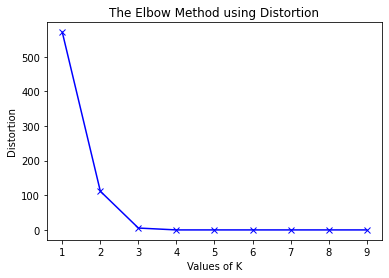

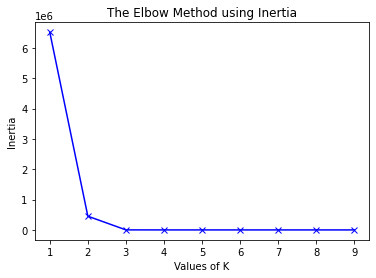



Elbow curves of mdata_3_1_trans are as follows:
Distortion Values:
1 : 822.6774843841238
2 : 263.0598537152418
3 : 12.74754878398196
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 13651375.0
2 : 2512750.0
3 : 6500.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


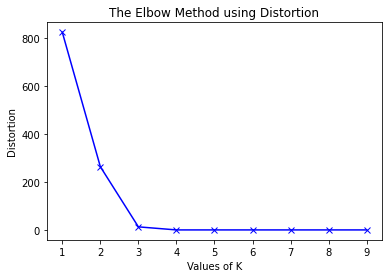

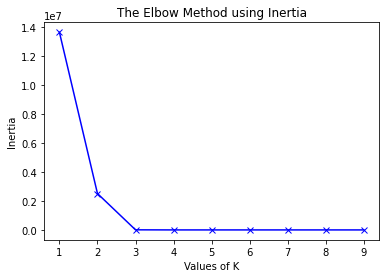



Elbow curves of mdata_2_1_trans are as follows:
Distortion Values:
1 : 393.08475549173886
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 3090312.5
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


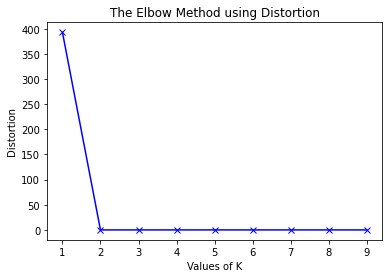

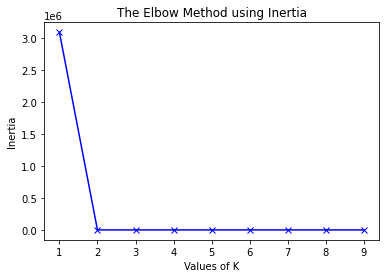



Elbow curves of mdata_1_trans are as follows:
Distortion Values:
1 : 497.51884386423006
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 4950500.0
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


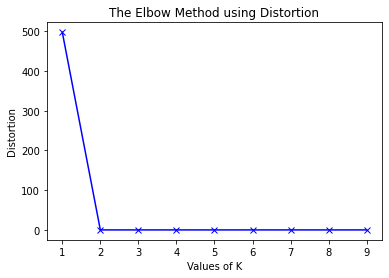

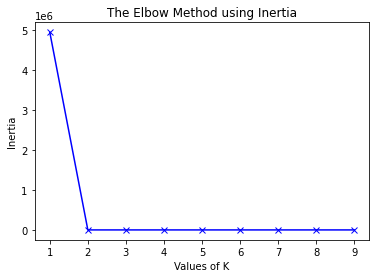



Elbow curves of rdata_daily_trans are as follows:
Distortion Values:
1 : 8844656.77585766
2 : 7073924.215067062
3 : 6246032.308339245
4 : 5882937.157021162
5 : 5614438.894475746
6 : 5330497.95197867
7 : 5200327.358792777
8 : 5014158.483828699
9 : 4937986.558447357

Inertia Values:
1 : 3.710226699981823e+16
2 : 2.196535732754648e+16
3 : 1.694508907201236e+16
4 : 1.4813973003127958e+16
5 : 1.3175331421647648e+16
6 : 1.2142510084441124e+16
7 : 1.1335233965710134e+16
8 : 1.053909577429564e+16
9 : 1.0208340522019214e+16


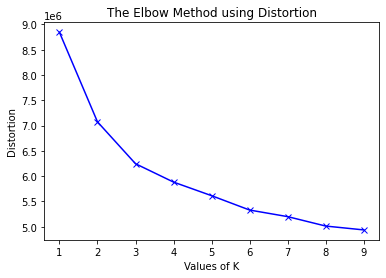

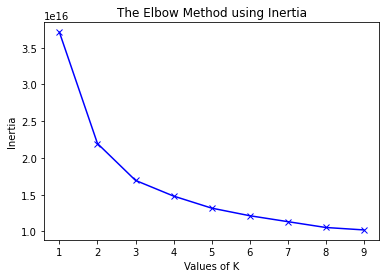

In [ ]:
# Define distortion and inertia above this cell. Use info that is available on geeksforgeeks

# Declaring lists that will capture the values of distortion and inertia
distortions = []
inertias = []

# Declaring dictionaries that will map the values of k and distortion, inertia values respectively
mapping1 = {}
mapping2 = {}

# Value of K will range from 1 to 10
K = range(1, 10)

# For all the transformed pandas dataframes, elbow curve plots will be printed in the following loop.
for i in trans_data_saved:  
  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(trans_data_saved[i])
      kmeanModel.fit(trans_data_saved[i])

      # Values of distortion will be appended to the list declared above
      distortions.append(sum(np.min(cdist(trans_data_saved[i], kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / trans_data_saved[i].shape[0])
      # Values of inertia will be appended to the list declared above
      inertias.append(kmeanModel.inertia_)

      # The below two lines of code will handle the mapping of k with distortion and inertia values.
      mapping1[k] = sum(np.min(cdist(trans_data_saved[i], kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / trans_data_saved[i].shape[0]
      mapping2[k] = kmeanModel.inertia_
  print()
  print('Elbow curves of', i, 'are as follows:')
  print('Distortion Values:')
  for key, val in mapping1.items():
      print(f'{key} : {val}')    
  print()
  print('Inertia Values:')
  for key, val in mapping2.items():
      print(f'{key} : {val}')

  # The below lines of code will generate plots with the distortion values
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method using Distortion')
  plt.show()

  # The below lines of code will generate plots with the inertia values
  plt.plot(K, inertias, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method using Inertia')
  plt.show()
  print()
  distortions = []
  inertias = []  
  mapping1 = {}
  mapping2 = {}

### Implementing the algorithm by using the actual data

In [ ]:
# Fit and Evaluate functions with PCA as a parameter

def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))
    

class KMeans:
    def __init__(self, n_clusters, max_iter=500):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, xarray_data, PCA = True, pass_trans_data = True):

      ''' This function fits the K-means model to the data that is passed to it.
          Parameters that this function will accept are as follows:
          1. xarray_data = string of the name of the original xarray file
          2. PCA (bool) = whether or not PCA has to be applied. Default value is True
          3. pass_trans_data (bool) = whether saved data has to be passed. If False, data will be transformed instantly. Default value is True.'''

      # The following block will run if user wants PCA to be applied to the data
      if PCA == True:
        # The following code will be executed if the user wants the saved transformed dataframe to be considered.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list which holds the values of the parameters that are being passed to the function
          path = str(k[1]) # path will hold the first parameter's value
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X_train = pd.read_csv(fullpath, index_col=[0]) # saved transformed dataframe will be read
          X_train = datanormalization(X_train) # the data will be normalized
          X_train = np.array(PCA_transform(X_train)) # X_train in the form of a numpy array will hold the data to which PCA has been applied 

        

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
              then the rest are initialized with probabilities proportional to their distances to the first point.'''
          
          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]

          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, and assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids) # Calling the function defined above
                  centroid_idx = np.argmin(dists) # Assigning points to the nearest centroid
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1

        # If the user does not want the saved transformed data to be used, the below block of code will be executed    
        else:
          X_train = datatransformation(xarray_data) # Transforming the data
          X_train = datanormalization(X_train) # Normalizing the data
          X_train = np.array(PCA_transform(X_train)) # Applying PCA to the data and storing it in the form of a numpy array

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
              then the rest are initialized with probabilities proportional to their distances to the first point.'''
          
          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]
          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, and assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids) # Calling the function defined above
                  centroid_idx = np.argmin(dists) # Assigning points to the nearest centroid
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1      

      # If the user does not want PCA to be applied to the data, the below block of code will be executed
      else:
        # The following code will be executed if the user wants the saved transformed dataframe to be considered.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list which holds the values of the parameters that are being passed to the function
          path = str(k[1]) # path will hold the first parameter's value
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X_train = pd.read_csv(fullpath, index_col=[0]) # saved transformed dataframe will be read
          X_train = np.array(datanormalization(X_train)) # the data will be normalized and stored in the form of a numpy array

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
          # then the rest are initialized with probabilities proportional to their distances to the first point. '''
          
          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]
          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, and assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids) # Calling the function defined above
                  centroid_idx = np.argmin(dists) # Assigning points to the nearest centroid
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1

        # If the user does not want the saved transformed data to be used, the below block of code will be executed        
        else:
          X_train = datatransformation(xarray_data) # Transforming the data
          X_train = np.array(datanormalization(X_train)) # Normalizing the data and storing it in the form of a numpy array

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
           then the rest are initialized w/ probabilities proportional to their distances to the first point.'''

          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]
          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids)
                  centroid_idx = np.argmin(dists)
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1


    def evaluate(self, z, PCA = True, pass_trans_data = True):
      ''' This function evaluates and assigns data points to clusters
          Parameters that this function will accept are as follows:
          1. z = string of the name of the original xarray file
          2. PCA (bool) = whether or not PCA has to be applied. Default value is True.
          3. pass_trans_data (bool) = whether saved data has to be passed. If False, data will be transformed instantly. Default value is True.'''
      
      # The following block of code will be executed if the user wants PCA to be applied to the data.
      if PCA == True:
        # The following code will be executed if the user wants the function to consider already saved transformed data.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list that holds the values of all the parameters that are being passed to the function
          path = str(k[1]) # path will capture the value of the first parameter
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X = pd.read_csv(fullpath,index_col=[0]) # Already saved transformed dataframe will be read
          Y = datanormalization(X) # Data will be normalized here
          Y = np.array(PCA_transform(Y)) # PCA will be applied to the data and stored as a numpy array.

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []

          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding class centers and cluster numbers as columns to the dataframe
          transformed_data['clusterid'] = centroid_idx 

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']] #+ [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data # Storing the data along with the index
          transformed_data = transformed_data.reset_index() # Resetting the index of the dataframe

          return centroid, centroid_idx, transformed_data

        # If the user does not want saved data to be considered by the function, the below block will be executed
        else:
          X = datatransformation(z) # Transforming the original data into a pandas dataframe
          Y = datanormalization(X) # Normalizing the transformed data
          Y = np.array(PCA_transform(Y)) # Applying PCA to the data and storing it as a numpy array

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []
          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding class centers and cluster numbers as columns to the dataframe
          transformed_data['clusterid'] = centroid_idx

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']]# + [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data
          transformed_data = transformed_data.reset_index()

          return centroid, centroid_idx, transformed_data

      # The following block of code will be executed if the user does not want PCA to be applied to the data.
      else:
        # If the user wants already saved transformed data to be considered, the below code will be executed.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list that holds the values of all the parameters that are being passed to the function
          path = str(k[1]) # path will hold the value of the first parameter
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X = pd.read_csv(fullpath,index_col=[0]) # Already saved transformed data will be read
          Y = np.array(datanormalization(X)) # The data will be normalized and saved as a numpy array.

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []

          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding class centers and cluster numbers as columns to the dataframe
          # transformed_data['Class_Center'] = centroid
          transformed_data['clusterid'] = centroid_idx   

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']]# + [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data
          transformed_data = transformed_data.reset_index()

          return centroid, centroid_idx, transformed_data

        # If the user does not want saved data to be considered by the function, the below block will be executed
        else:
          X = datatransformation(z) # Transforming the original data into a pandas dataframe
          Y = np.array(datanormalization(X)) # Normalizing the data and saving it as a numpy array

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []
          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding cluster numbers as a column to the dataframe
          transformed_data['clusterid'] = centroid_idx

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']] #+ [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data
          transformed_data = transformed_data.reset_index()              

          return centroid, centroid_idx, transformed_data

In [ ]:
# Function to modify the dataframe returned by the evaluate function.

def modify_date(df):
  # This function will accept a dataframe as an input.

  # Since the dataframe returned by the evaluate function has date as a string, the following line will convert it to the specified date format.
  df['index'] = pd.to_datetime(df['index'], format='%Y-%m-%d') 
  # A new column called time_step will be added which will have the year followed by the day of the year.
  df['time_step'] = df['index'].dt.strftime("%Y-%j")
  # Dropping the column 'index'
  df = df.drop(['index'], axis=1)
  return df

In [ ]:
# Function that saves the modified dataframe

def save_df(df,df_name):
  # This function will accept a dataframe and its name as an input.

  # The following code will save the dataframe to the location specified below.
  path = '/content/drive/MyDrive/Courses/IS-700-Independent_Study/'+df_name+'.csv'
  df.to_csv(path,index=True)
  return

# **Fitting the model to every data file.**

## **Mock_v4.nc**

In [ ]:
centers = 3
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_4',PCA=True,pass_trans_data=True)

class_centers_mdata_4, classification_mdata_4, transformed_data_mdata_4 = kmeans.evaluate('mdata_4',PCA=True,pass_trans_data=True)
transformed_data_mdata_4 = modify_date(transformed_data_mdata_4)
save_df(transformed_data_mdata_4,'transformed_data_mdata_4')

classification_mdata_4

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]

## **Mock_v3.1.nc**

In [ ]:
centers = 3
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_3_1',PCA=True,pass_trans_data=True)

class_centers_mdata_3_1, classification_mdata_3_1, transformed_data_mdata_3_1 = kmeans.evaluate('mdata_3_1',PCA=True,pass_trans_data=True)
transformed_data_mdata_3_1 = modify_date(transformed_data_mdata_3_1)
save_df(transformed_data_mdata_3_1,'transformed_data_mdata_3_1')

classification_mdata_3_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]

## **Mock_v2.1.nc**

In [ ]:
centers = 2
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_2_1',PCA=True,pass_trans_data=True)

class_centers_mdata_2_1, classification_mdata_2_1, transformed_data_mdata_2_1 = kmeans.evaluate('mdata_2_1',PCA=True,pass_trans_data=True)
transformed_data_mdata_2_1 = modify_date(transformed_data_mdata_2_1)
save_df(transformed_data_mdata_2_1,'transformed_data_mdata_2_1')

classification_mdata_2_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## **Mock_v1.nc**

In [ ]:
centers = 2
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_1',PCA=True,pass_trans_data=True)

class_centers_mdata_1, classification_mdata_1, transformed_data_mdata_1 = kmeans.evaluate('mdata_1',PCA=True,pass_trans_data=True)
transformed_data_mdata_1 = modify_date(transformed_data_mdata_1)
save_df(transformed_data_mdata_1,'transformed_data_mdata_1')

classification_mdata_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## **ERA5_meteo_sfc_2021_daily.nc**

In [ ]:
centers = 3
kmeans = KMeans(n_clusters=centers)
kmeans.fit('rdata_daily',PCA=True,pass_trans_data=True)

class_centers_rdata_daily, classification_rdata_daily, transformed_data_rdata_daily = kmeans.evaluate('rdata_daily',PCA=True,pass_trans_data=True)
transformed_data_rdata_daily = modify_date(transformed_data_rdata_daily)
save_df(transformed_data_rdata_daily,'transformed_data_rdata_daily')

classification_rdata_daily

[2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
